# Likelihood Optimization of gas Kinematics in IFUs (LOKI)
## Fitting example: MIRI + Voronoi binning

Michael Reefe

This example notebook provides a tutorial on how to run LOKI on a channel 3A MIRI/MRS cube, while utilizing Voronoi binning to group spaxels up into regions with some minimum SNR.

In [1]:
using Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()
Pkg.precompile()
using Loki
using Unitful 

  Activating project at `~/Dropbox/Astrophysics/Codes/Loki`
Precompiling packages...
  31885.9 ms  ✓ Loki
  1 dependency successfully precompiled in 35 seconds. 311 already precompiled.


Now we want to load in our data. For this example, we'll be using the channel 1 data for NGC 7469, which is located in the same folder as this notebook. Unfortunately the JWST reduced data does not include a redshift, so we must provide the redshift ourselves.  We can use the `from_fits` function to load in the JWST-formatted FITS files, along with the redshift.

In [2]:
# The redshift of the target object: NGC 628 (distance = 7.3 Mpc)
z = 0.0017051
# The semicolon at the end suppresses printing the output Observation object, which is long and not very enlightening
obs = from_fits(["jw04486-o002_t002_miri_ch3-short_s3d.fits.gz"], z);

[ Info: Initializing DataCube struct from jw04486-o002_t002_miri_ch3-short_s3d.fits.gz


Next, we create some variables that we will use later. We will be fitting channel 1 data, and we can take the `name` property from the Observation object we just loaded in to get the name of the target. Here, `run_name` is just a unique identifier that we will use for this run.

In [3]:
channel = :A3
nm = "NGC_628"
run_name = "$(nm)_ch$(channel)_voronoi"

"NGC_628_chA3_voronoi"

Before fitting, we want to do some pre-processing on the data. We want to convert the data to the rest-frame, mast out / interpolate any bad pixels, and replace the JWST pipeline-generated errors with some more realistic ones.  All of this is achieved in the next block of code. 

In [4]:
if isfile("$nm.channel$channel.rest_frame.fits")
    # If we've already performed this step in a previous run, just load in the pre-processed data
    obs = from_fits(["$nm.channel$channel.rest_frame.fits"], obs.z);
    
else
    obs.name = nm

    # Convert to rest-frame wavelength vector, and mask out bad spaxels
    correct!(obs)

    # We interpolate any rogue NaNs using a linear interpolation, since the MPFIT minimizer does not handle NaNs well.
    interpolate_nans!(obs.channels[channel])

    # We calculate the statistical errors (i.e. the standard deviation of the residuals with a cubic spline fit)
    # and replace the errors in the cube with these, since the provided errors are typically underestimated.
    # You can skip this step if you wish to use the default errors.
    calculate_statistical_errors!(obs.channels[channel])
    
    # Save the pre-processed data as a FITS file so it can be quickly reloaded later in case we need to rerun the fit
    save_fits(".", obs, [channel]);
end

[ Info: Using SFD98 dust map at (α=24.1625°, δ=15.79735°): E(B-V)=0.07049660277166701
[ Info: Interpolating NaNs in cube with channel 3, band SHORT:
[ Info: Calculating statistical errors for each spaxel...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[ Info: Writing FITS file from Observation object


Next, we need to actually apply the voronoi binning, which we do using the `voronoi_rebin!` function.  The only argument here is the target SNR that you'd like to bin to.

(Make sure this is called *after* you load in the observation object in the previous cell, as the voronoi binning information is not saved to the fits file)

In [5]:
# Finally, we apply the voronoi binning with an SNR target of 100 (which is a bit high, but this is just for demonstrational purposes)
# We also restrict the wavelength region to just around the [Ne II] line at 12.81 um, using that as our proxy for 
# the whole cube's SNR.
using VoronoiBinning
voronoi_rebin!(obs.channels[channel], 100., (12.8u"μm", 12.82u"μm"), WeightedVoronoi())

# Note: the wavelength range and "WeightedVoronoi" arguments are both optional.
#     By default, the SNR is calculated over the entire wavelength range of the cube, and the WeightedVoronoi is the default binning strategy
#     Other binning strategies you may choose from are CentroidalVoronoi or InitialVoronoi, but I'd recommend mostly just sticking with the
#     WeightedVoronoi unless you are getting poor results with it

[ Info: Performing Voronoi rebinning with target S/N=100.0


39×41 Matrix{Int64}:
 0  0   0   0   0   0   0   0   0   0  …   0   0   0   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   0      0   0   0   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   0      0   0   0   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   0      0   0   0   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   6      0   0   0   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   0  …   0   0   0   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   6     50  50  50   0   0   0   0  0  0
 0  0   0   0   0   0   0   0   0   6     50  50  50  50  65  65   0  0  0
 0  0   0   0   0   0   0   0   6   6     50  50  50  65  65  65  65  0  0
 0  0   0   0   0   0   0   0   4   4     50  50  50  65  65  65  65  0  0
 ⋮                  ⋮                  ⋱               ⋮                 ⋮
 0  0   0  63  63  63  63  63  63  53  …   0   0   0   0   0   0   0  0  0
 0  0  63  63  63  63  63  63  53  53      0   0   0   0   0   0   0  0  0
 0  

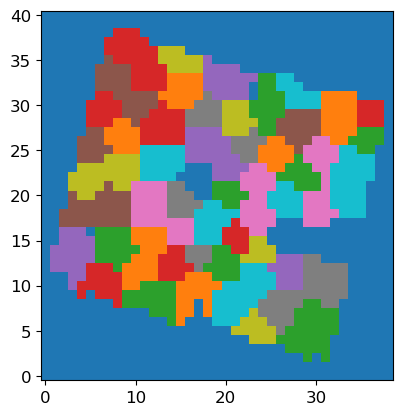

In [6]:
# Plot the voronoi bins for visualization purposes
using PyPlot 

base_cmap = plt.cm.tab10
N = 20
colors = [base_cmap(i/N) for i in 1:N]
loop_cmap = plt.matplotlib.colors.ListedColormap(colors)
loop_cmap.set_bad(color="k")
norm = plt.matplotlib.colors.BoundaryNorm(-0.5:N-0.5, N)

plt.imshow(obs.channels[channel].voronoi_bins' .% N, origin=:lower, cmap=loop_cmap, norm=norm)
plt.gcf()

In [7]:
plt.close()

Finally, we create the `CubeFitter` object and call the `fit_cube!` function to fit the data.

Note: this may take a while to run!

In [8]:
# To see a full list of keyword arguments, please refer to the docstring, which can be accessed by typing `?CubeFitter` in the command
# line after importing Loki.
cube_fitter = CubeFitter(
    obs.channels[channel], 
    obs.z, 
    run_name; 
    parallel=true, 
    parallel_strategy="pmap",
    plot_spaxels=:pyplot, 
    plot_maps=true, 
    save_fits=true,
    silicate_absorption="d+",
    extinction_screen=true, 
    use_pah_templates=true, 
    fit_sil_emission=false, 
    fit_stellar_continuum=false, 
    fit_all_global=true,
    save_full_model=true, 
    map_snr_thresh=3., 
)

# Call the fit_cube! function on the cube_fitter object, using the aperture we defined.
fit_cube!(cube_fitter)

[ Info: Preparing output directories
┌ Info: 
│ 
│ #############################################################################
│ ######## BEGINNING FULL CUBE FITTING ROUTINE FOR NGC_628_chA3_voronoi ########
│ #############################################################################
│ 
│ ------------------------
│ Worker Processes:     1
│ Threads per process:  1
└ ------------------------
[ Info: ===> Preparing output data structures... <===
[ Info: ===> Performing initial fit to the sum of all spaxels... <===
[ Info: Integrating spectrum across the whole cube...
[ Info: Loading in previous fit results (if any...)
[ Info: ===> Beginning individual spaxel fitting... <===
[ Info: Number of spaxels to fit: 66


Progress: 100%|█████████████████████████████████████████| Time: 0:03:57


[ Info: ===> Generating parameter maps and model cubes... <===


Progress: 100%|███████████████████████████| Time: 0:00:23 (14.66 ms/it)


[ Info: ===> Plotting parameter maps... <===
┌ Warning: You have requested combined plots for the lines [:OII_3727A, :OII_3729A], but at least one of these lines was not fit!
└ @ Loki ~/Dropbox/Astrophysics/Codes/Loki/src/core/output.jl:665
[ Info: ===> Writing FITS outputs... <===
[ Info: ===> Writing CSV tables... <=== 
┌ Info: 
│ 
│ #############################################################################
│ ################################### Done!! ##################################
└ #############################################################################


(CubeFitter{Float64, Int64, Quantity{Float64, 𝐌 𝐓⁻², Unitful.FreeUnits{(erg, Hz⁻¹, cm⁻², s⁻¹, sr⁻¹), 𝐌 𝐓⁻², nothing}}, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(km, s⁻¹), 𝐋 𝐓⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(μm,), 𝐋, nothing}}}(DataCube{Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(μm,), 𝐋, nothing}}}, Array{Quantity{Float64, 𝐌 𝐓⁻², Unitful.FreeUnits{(erg, Hz⁻¹, cm⁻², s⁻¹, sr⁻¹), 𝐌 𝐓⁻², nothing}}, 3}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(μm,), 𝐋, nothing}}[11.531587680552816 μm, 11.534083425003077 μm, 11.536579709599286 μm, 11.539076534458344 μm, 11.541573899697175 μm, 11.54407180543274 μm, 11.546570251782015 μm, 11.549069238862002 μm, 11.551568766789726 μm, 11.554068835682246 μm  …  13.420572434486022 μm, 13.423477005833918 μm, 13.426382205808853 μm, 13.429288034546873 μm, 13.432194492184072 μm, 13.435101578856553 μm, 13.438009294700457 μm, 13.440917639851953 μm, 13.443826614447236 μm, 13.446736218622544 μm], Quantity{Float64, 𝐌 𝐓⁻², Unitful.FreeUnits{(erg, 

And the results can be found in the "output_[run_name]" directory, just like the other examples! Here is an example of a voronoi bin spectral fit:

![](./NGC628.voronoi_bin_36.png)

The orange line shows the final model.  The decomposed components of the model consist of:
- Thermal dust continuum, in gray
- PAHs, in blue
- Emission lines, in purple
- Extinction, in dotted gray (read from the right axis)

And here's a showcase of the voronoi binning, showing a 2D map of the [Ne II] amplitude. 
NOTE: Voronoi bins, by their nature, have non-uniform sizes, so when looking at emission maps like this, it is more informative to look at maps of *intensity* (flux per solid angle) rather than *flux*.  Flux maps are still generated in these cases, but bigger bins will naturally have larger fluxes, and vice versa, so they should be used with caution in any scientific analysis.

![](./NGC628.NeII_12813m.amp.png)
